In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import SGD, Adam
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import seaborn as sns

In [ ]:
device = torch.device('cuda')

In [ ]:
Traindata = datasets.FashionMNIST(root = './', train = True, transform = ToTensor(), download = True)
Testdata = datasets.FashionMNIST(root = './', train = False, transform = ToTensor(), download = True)

100%|██████████| 26421880/26421880 [00:06<00:00, 3943409.37it/s] 


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 270533.73it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5003864.69it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21832433.76it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
Trainloader = DataLoader(Traindata, shuffle = True, batch_size = 32)
Testloader = DataLoader(Testdata, batch_size = 32)

In [ ]:
class myNet (nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 300),
        nn.ReLU(),
        nn.Linear(300, 400),
        nn.ReLU(),
        nn.Linear(400, 250),
        nn.ReLU(),
        nn.Linear(250, 150),
        nn.ReLU(),
        nn.Linear(150, 50)
        nn.ReLU()
        nn.Linear(50, 10)
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
def train(data, model, loss, optimizer):

  num_batches = len(data)
  total_loss = 0

  for images, targets in data:
    images = images.to(device)
    targets = targets.to(device)
    train_preds = model(images)
    L = loss(train_preds, targets)
    total_loss += L
    L.backward()
    optimizer.step()
    optimizer.zero_grad()

  avg_loss = total_loss / num_batches
  print(f"Average loss = {avg_loss}")

In [ ]:
def correct(output, target):
  predictions = output.argmax(1)
  return (predictions == target).sum()

In [ ]:
def test(data, model, loss):
  total_correct = 0
  total_loss = 0
  num_batches = len(data)
  num_imgs = len(data.dataset)

  for images, target in data:
    images = images.to(device)
    target = target.to(device)

    output = model(images)
    L = loss(output, target)
    total_loss += L
    total_correct += correct(output, target)

  avg_loss = total_loss/num_batches
  accuracy = total_correct/ num_imgs

  print(f'Totall Correct: {total_correct}')
  print(f'Average Loss: {total_loss}')
  print(f'Accuracy: {accuracy}')

  return avg_loss, accuracy

In [ ]:
model = myNet().to(device)
Loss = nn.CrossEntropyLoss()
lr = [0.001, 0.01, 0.05, 0.1]
loss_alpha = {}
m = 0

for alpha in lr:
  optimizer = torch.optim.SGD(model.parameters(), lr = alpha)
  epochs = 50
  for i in range(epochs):
    print(f"training epoch = {i}")
    train(Trainloader, model, Loss, optimizer)
    print('**********\ntrain accuracy:')
    a, b = test(Trainloader, model, Loss)
    print('**********\ntest accuracy:')
    c, d = test(Testloader, model, Loss)
    loss_alpha[m] = [alpha, i, a.item(), b.item(), c.items(), d.items()] # a = train_loss, b = train_accuracy, c = test_loss, d = test_accuracy
    m += 1

training epoch = 0
Average loss = 2.299551010131836
**********
train accuracy:
Totall Correct: 7802
Average Loss: 4301.7119140625
Accuracy: 0.13003332912921906
**********
test accuracy:
Totall Correct: 1270
Average Loss: 718.1210327148438
Accuracy: 0.12700000405311584
training epoch = 1
Average loss = 2.2873988151550293
**********
train accuracy:
Totall Correct: 12774
Average Loss: 4273.3740234375
Accuracy: 0.21289999783039093
**********
test accuracy:
Totall Correct: 2137
Average Loss: 713.4166870117188
Accuracy: 0.21369999647140503
training epoch = 2
Average loss = 2.264636278152466
**********
train accuracy:
Totall Correct: 27706
Average Loss: 4207.17578125
Accuracy: 0.46176666021347046
**********
test accuracy:
Totall Correct: 4547
Average Loss: 702.4074096679688
Accuracy: 0.4546999931335449
training epoch = 3
Average loss = 2.191044330596924
**********
train accuracy:
Totall Correct: 26932
Average Loss: 3939.5390625
Accuracy: 0.44886666536331177
**********
test accuracy:
Totall Co

In [ ]:
loss_df = pd.DataFrame(data = loss_alpha.values(), index = loss_alpha.keys(), columns = ['learning_rate', 'epoch', 'train_loss', 'train_accuracy', 'test_loss', 'test_accuracy'])

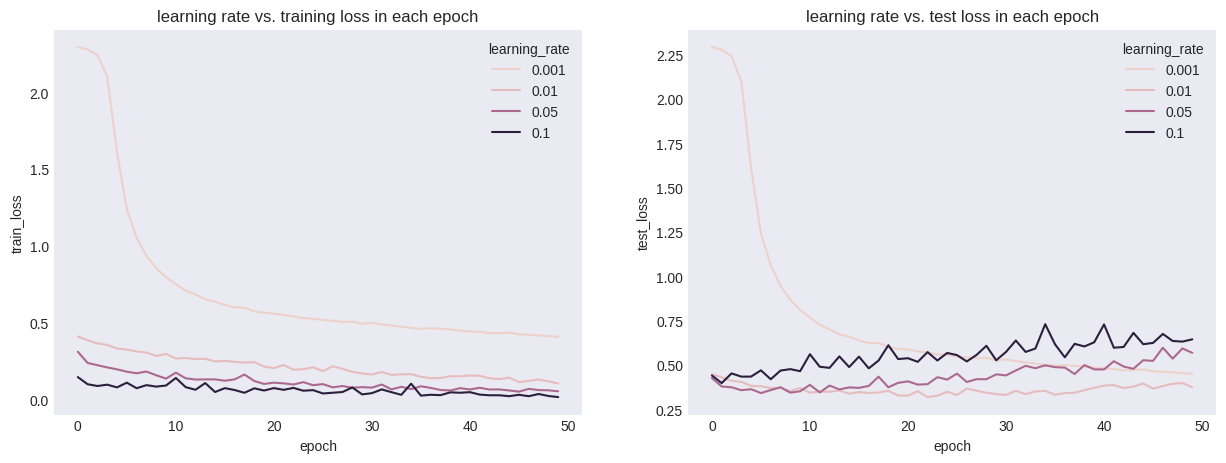

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (15, 5))
plt.style.use('fast')
sns.lineplot(data = loss_df, x = 'epoch', y = 'train_loss', hue = 'learning_rate', ax = ax[0, 0]).set_title('learning rate vs. training loss in each epoch')
sns.lineplot(data = loss_df, x = 'epoch', y = 'test_loss', hue = 'learning_rate', ax = ax[0, 1]).set_title('learning rate vs. test loss in each epoch');

As can be interpreted from figures above, learning rate 0.01 is overally better in comparison with other values.
Also, it can be seen that both train and test losses are at their minimum in about 20 to 25 epochs.
Lets find out its exact number!

In [ ]:
loss_df.loc[loss_df.loc[loss_df['learning_rate'] == 0.01]['test_loss'].argmin()]['epoch']

22.0

Well! we consider 22 epochs and learning rate 0.01 for our model!

In [ ]:
model = myNet().to(device)
Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
loss_train = []
loss_test = []
accuracy_train = []
accuracy_test = []
epochs = 22
for epoch in range(epochs):
  print(f"training epoch = {epoch}")
  train(Trainloader, model, Loss, optimizer)
  print('**********\ntrain accuracy:')
  a, b = test(Trainloader, model, Loss)
  loss_train.append(a.item())
  accuracy_train.append(b.item())
  print('**********\ntest accuracy:')
  a, b = test(Testloader, model, Loss)
  loss_test.append(a.item())
  accuracy_test.append(b.item())

training epoch = 0
Average loss = 1.2211642265319824
**********
train accuracy:
Totall Correct: 47004
Average Loss: 1180.33837890625
Accuracy: 0.7833999991416931
**********
test accuracy:
Totall Correct: 7673
Average Loss: 206.26022338867188
Accuracy: 0.767300009727478
training epoch = 1
Average loss = 0.5702489614486694
**********
train accuracy:
Totall Correct: 48984
Average Loss: 958.3594360351562
Accuracy: 0.8163999915122986
**********
test accuracy:
Totall Correct: 8089
Average Loss: 169.5240478515625
Accuracy: 0.808899998664856
training epoch = 2
Average loss = 0.4709644615650177
**********
train accuracy:
Totall Correct: 50504
Average Loss: 837.1503295898438
Accuracy: 0.8417333364486694
**********
test accuracy:
Totall Correct: 8318
Average Loss: 151.2795867919922
Accuracy: 0.8317999839782715
training epoch = 3
Average loss = 0.4148542284965515
**********
train accuracy:
Totall Correct: 51886
Average Loss: 702.796630859375
Accuracy: 0.8647666573524475
**********
test accuracy:
T